In [101]:
from sklearn.metrics import root_mean_squared_error, accuracy_score, precision_recall_fscore_support,mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, RFE, mutual_info_regression
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.svm import SVC, LinearSVC
from keras.utils import to_categorical
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV
import networkx as nx
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import itertools

In [102]:
data_dir = "finalData.csv"
df = pd.read_csv(data_dir)

In [103]:
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

In [104]:
# renaming the columns
df.columns = ['Date', 'Home Team', 'Away Team', 'Full Time Home Goals', 'Full Time Away Goals', 'Full Time Result',       
'Half Time Home Goals', 'Half Time Away Goals', 'Half Time Result', 'Referee', 'Home Shots', 'Away Shots', 'Home Shots on Target',   
'Away Shots on Target', 'Home Corners', 'Away Corners', 'Home Fouls', 'Away Fouls', 'Home Yellow Cards', 'Away Yellow Cards',     
'Home Red Cards', 'Away Red Cards', 'Home Possession', 'Away Possession', 'Home Passes Completed', 'Home Passes PCT',
'Home Progressive Passes', 'Home Progressive Passing Distance', 'Home xG', 'Home Take Ons Won', 'Home Take Ons', 
'Home Interceptions', 'Home Blocks', 'Home Touches', 'Home Touches Def 3rd', 'Home Touches Mid 3rd', 'Home Touches Att 3rd',
'Home Carries', 'Home Carries Progressive Distance', 'Home Tackles', 'Home Tackles Won', 'Away Passes Completed',
'Away Passes PCT', 'Away Progressive Passes', 'Away Progressive Passing Distance', 'Away xG',
'Away Take Ons Won', 'Away Take Ons', 'Away Interceptions', 'Away Blocks', 'Away Touches', 'Away Touches Def 3rd',
'Away Touches Mid 3rd', 'Away Touches Att 3rd', 'Away Carries', 'Away Carries Progressive Distance', 'Away Tackles',
'Away Tackles Won']

In [105]:
# ensure sorted by date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values(by='Date')

# each season starts at 08 and ends at 05 of next year - 2000-2001 season will be the 2000 season
def get_season(date):
    if date.month >= 8:  
        return (date.year)
    else:  
        return (date.year - 1)

df['Season'] = df['Date'].apply(get_season)
df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})

In [106]:
def calculate_season_points(df):
    df['Home Team Points'] = 0
    df['Away Team Points'] = 0

    for idx, row in df.iterrows():
        if row['Match Outcome'] == 1:  
            df.at[idx, 'Home Team Points'] = 3
            df.at[idx, 'Away Team Points'] = 0
        elif row['Match Outcome'] == 0: 
            df.at[idx, 'Home Team Points'] = 1
            df.at[idx, 'Away Team Points'] = 1
        elif row['Match Outcome'] == -1:  
            df.at[idx, 'Home Team Points'] = 0
            df.at[idx, 'Away Team Points'] = 3

    df['Home Total Seasonal Points'] = (df.groupby(['Home Team', 'Season'])['Home Team Points'].cumsum())
    df['Away Total Seasonal Points'] = (df.groupby(['Away Team', 'Season'])['Away Team Points'].cumsum())
    # df['Seasonal Point Difference'] = df['Home Total Seasonal Points'] - df['Away Total Seasonal Points']
    # df.drop(columns=['Home Team Points', 'Away Team Points'], inplace=True)

    return df
df = calculate_season_points(df)

In [107]:
features = [
    # Home Advantage
    "Home Team",
    "Away Team",
    "Match Outcome",
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    
    # Extra
    "Full Time Result",
    'Date',
    'Season'
]

updated_df = df[features].copy()
updated_df.dropna(inplace=True)

In [108]:
numerical_features = [
    # Home Advantage,
    "Full Time Home Goals",
    "Full Time Away Goals",
    
    # Attacking Strength
    "Home Shots on Target", "Away Shots on Target",
    "Home Progressive Passes", "Away Progressive Passes",
    "Home Touches Att 3rd", "Away Touches Att 3rd",
    "Home Take Ons Won", "Away Take Ons Won",
    "Home Corners", "Away Corners",
    
    # Midfield Strength
    "Home Touches Mid 3rd", "Away Touches Mid 3rd",
    "Home Passes Completed", "Away Passes Completed",
    "Home Passes PCT", "Away Passes PCT",
    "Home Carries", "Away Carries",
    
    # Defensive Strength
    "Home Tackles", "Away Tackles",
    "Home Tackles Won", "Away Tackles Won",
    "Home Blocks", "Away Blocks",
    "Home Interceptions", "Away Interceptions",
    ]

In [109]:
def standardisation(df, terms=numerical_features):
    scaler = StandardScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# normalises a specific set of columns
def normalisation(df, terms=numerical_features):
    scaler = MinMaxScaler()
    df[terms] = scaler.fit_transform(df[terms])
    return df

# label encoding - use for boosting models
def label_encoding(df, col=['Home Team', 'Away Team'], dataframe=True):
    label_encoder = LabelEncoder()
    if dataframe:
        for c in col:
            df[c] = label_encoder.fit_transform(df[c])
    else:
        df = label_encoder.fit_transform(df)
    return df

Explained Variance Ratio:  [3.16576232e-01 8.45400333e-02 5.77480471e-02 4.98413595e-02
 3.97925540e-02 3.75659122e-02 3.41837323e-02 3.31313049e-02
 2.44209614e-02 2.42266364e-02 2.10247585e-02 1.90175701e-02
 1.81513320e-02 1.75881751e-02 1.65469751e-02 1.53220145e-02
 1.47904115e-02 1.39839348e-02 1.30258432e-02 1.25829526e-02
 1.18487923e-02 1.10295738e-02 1.02416566e-02 9.20479283e-03
 8.43066550e-03 7.85997645e-03 7.05260791e-03 6.22120658e-03
 5.48273633e-03 4.98185979e-03 4.62467530e-03 4.33793785e-03
 4.22584095e-03 4.05631205e-03 3.62936796e-03 3.54816995e-03
 3.00574141e-03 2.89590597e-03 2.75576708e-03 2.51615232e-03
 2.50223162e-03 2.20056031e-03 2.13312656e-03 1.82915504e-03
 1.59959876e-03 1.57101208e-03 1.52742630e-03 1.23717945e-03
 1.17426109e-03 1.06742370e-03 7.73061379e-04 2.30962891e-04
 1.20645223e-04 1.70988808e-05 2.93059148e-06 2.73610511e-06
 1.10141878e-07 4.34644920e-18]
Number of components to retain 95% variance: 31


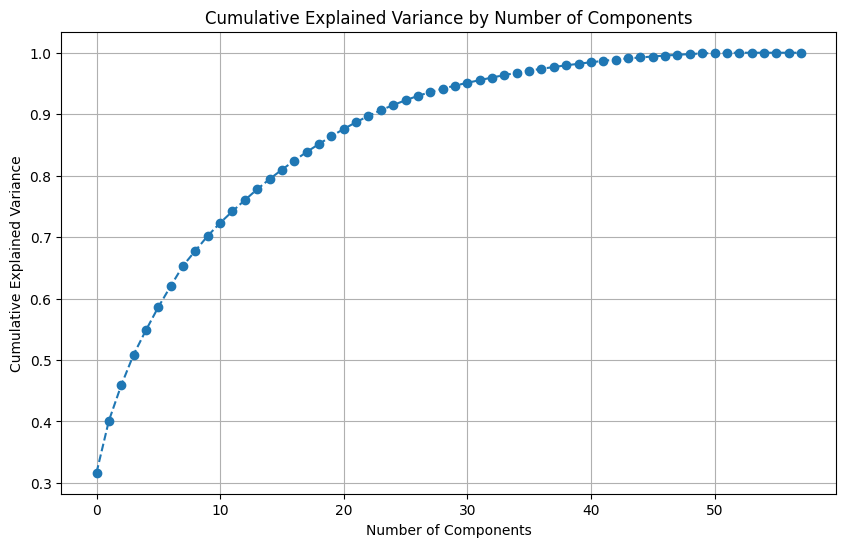

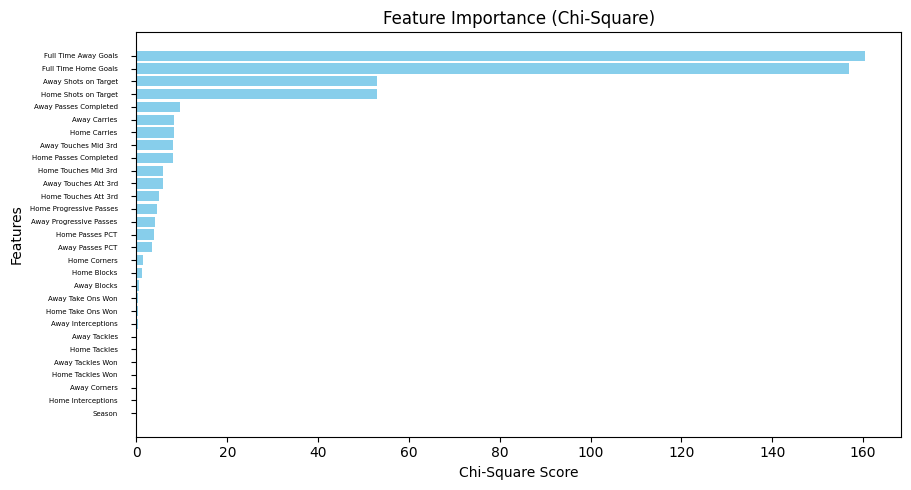

In [110]:
def pca(df):
    # drop the irrelevant terms
    featuresToDrop = ['Date', 'Home Team', 'Away Team', 'Full Time Result', 'Half Time Result', 'Referee']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    df2 = df.drop(featuresToDrop, axis=1)
    
    df2 = standardisation(df2, terms=list(df2.columns))
    
    pca = PCA()
    pca_components = pca.fit_transform(df2)
    
    # find the explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print("Explained Variance Ratio: ", explained_variance)

    # select number of components based on explained variance (e.g., 95% variance)
    cumulative_variance = explained_variance.cumsum()
    n_components = next(i for i, v in enumerate(cumulative_variance) if v >= 0.95) + 1
    print(f"Number of components to retain 95% variance: {n_components}")

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    
    return n_components
    
number_of_components = pca(df)



def chi_square(df):
    # organise dataset into X (training examples) and y (targets)
    featuresToDrop = ['Date', 'Home Team', 'Full Time Result', 'Away Team', 'Match Outcome']
    assert set(featuresToDrop).issubset(df.columns), "Some columns in featuresToDrop are missing in df"
    data = df.drop(featuresToDrop, axis=1)
    df['Match Outcome'] = df['Full Time Result'].map({'H': 1, 'D': 0, 'A': -1})
    target = df['Match Outcome']
    
    # chi2 scoring function requires non-negative input: normalisation
    data = normalisation(data, terms=list(data.columns))
    
    # collect the feature names
    feature_names = list(data.columns)
    
    # perform chi square selection    
    chi_select = SelectKBest(chi2, k=min(number_of_components, len(data.columns)))
    new_data = chi_select.fit_transform(data, target)
    
    # collect features
    selected_features = []
    for i, b in enumerate(chi_select.get_support()):
        if b:
            selected_features.append(feature_names[i])
    
    # get the chi-square scores for all features
    chi_scores = chi_select.scores_

    # create a dataFrame for easy visualization
    chi2_df = pd.DataFrame({'Feature': feature_names, 'Chi-Square Score': chi_scores})
    chi2_df = chi2_df.sort_values(by='Chi-Square Score', ascending=False)

    # plot the scores
    plt.figure(figsize=(10, 5))
    colours = ['skyblue' if i < number_of_components else 'gray' for i in range(len(chi2_df))]
    plt.barh(chi2_df['Feature'], chi2_df['Chi-Square Score'], color=colours)
    plt.xlabel('Chi-Square Score')
    plt.ylabel('Features')
    plt.title('Feature Importance (Chi-Square)')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest scores at the top
    plt.tight_layout()
    plt.tick_params(axis="y", pad=10, labelsize=5)
    plt.show()
    
    return chi2_df
    
chi2_df = chi_square(updated_df)   

In [111]:
def adjust_feature_weights(features, chi2_df):
    # Aggregate Home and Away importance scores
    aggregated_scores = {}
    for feature_pair in features:
        home_feature, away_feature = feature_pair
        home_score = chi2_df.loc[chi2_df['Feature'] == home_feature, 'Chi-Square Score'].values[0]
        away_score = chi2_df.loc[chi2_df['Feature'] == away_feature, 'Chi-Square Score'].values[0]
        aggregated_scores[feature_pair] = home_score + away_score

    # Sort features by aggregated importance
    sorted_features = sorted(aggregated_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Adjust scores using the /3 rule
    adjusted_scores = {}
    adjusted_scores[sorted_features[0][0]] = sorted_features[0][1]  # Most important feature remains unchanged
    
    for i in range(1, len(sorted_features)):
        current_feature, current_score = sorted_features[i]
        previous_feature, previous_score = sorted_features[i - 1]
        
        if current_score < previous_score / 3:
            current_score = previous_score / 3
        adjusted_scores[current_feature] = current_score

    # Assign adjusted scores equally to Home and Away features
    final_weights = {}
    for feature_pair, score in adjusted_scores.items():
        home_feature, away_feature = feature_pair
        final_weights[home_feature] = score / 2
        final_weights[away_feature] = score / 2
    
    return final_weights

def create_strength_features_separate(df, chi2_df):
    # Define feature pairs for each group
    attack_features = [
        ("Home Shots on Target", "Away Shots on Target"),
        ("Home Progressive Passes", "Away Progressive Passes"),
        ("Home Touches Att 3rd", "Away Touches Att 3rd"),
        ("Home Take Ons Won", "Away Take Ons Won"),
        ("Home Corners", "Away Corners")
    ]
    midfield_features = [
        ("Home Touches Mid 3rd", "Away Touches Mid 3rd"),
        ("Home Passes Completed", "Away Passes Completed"),
        ("Home Passes PCT", "Away Passes PCT"),
        ("Home Carries", "Away Carries")
    ]
    defense_features = [
        ("Home Tackles", "Away Tackles"),
        ("Home Tackles Won", "Away Tackles Won"),
        ("Home Blocks", "Away Blocks"),
        ("Home Interceptions", "Away Interceptions")
    ]
    
    # Adjust weights for each group
    attack_weights = adjust_feature_weights(attack_features, chi2_df)
    midfield_weights = adjust_feature_weights(midfield_features, chi2_df)
    defense_weights = adjust_feature_weights(defense_features, chi2_df)
    
    # Calculate strength scores for Home and Away
    def calculate_strength(feature_pairs, weights, team_type):
        strength_score = 0
        for home_feature, away_feature in feature_pairs:
            feature = home_feature if team_type == "Home" else away_feature
            strength_score += df[feature] * weights[feature]
        return strength_score

    # Compute Home and Away strengths for Attack, Midfield, and Defense
    df['Home Attack Strength'] = calculate_strength(attack_features, attack_weights, "Home")
    df['Away Attack Strength'] = calculate_strength(attack_features, attack_weights, "Away")
    df['Home Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Home")
    df['Away Midfield Strength'] = calculate_strength(midfield_features, midfield_weights, "Away")
    df['Home Defense Strength'] = calculate_strength(defense_features, defense_weights, "Home")
    df['Away Defense Strength'] = calculate_strength(defense_features, defense_weights, "Away")
    
    return df

updated_df = create_strength_features_separate(updated_df, chi2_df)


In [112]:
updated_df

,Home Team,Away Team,Match Outcome,Full Time Home Goals,Full Time Away Goals,Home Shots on Target,Away Shots on Target,Home Progressive Passes,Away Progressive Passes,Home Touches Att 3rd,...,Away Interceptions,Full Time Result,Date,Season,Home Attack Strength,Away Attack Strength,Home Midfield Strength,Away Midfield Strength,Home Defense Strength,Away Defense Strength
0,Arsenal,Leicester City,1,4.0,3.0,10.0,3.0,62,16,252,...,11,H,2017-08-11,2017,5276.186134,2358.243229,12111.988906,4166.751890,16.208599,22.559994
1,Brighton & Hove Albion,Manchester City,-1,0.0,2.0,2.0,4.0,5,87,51,...,9,A,2017-08-12,2017,1036.708746,5878.088278,3390.179910,14713.613676,14.874615,12.895485
2,Chelsea,Burnley,-1,2.0,3.0,6.0,5.0,48,26,203,...,13,A,2017-08-12,2017,4130.587885,1695.290296,9601.496670,5614.344215,10.814935,16.453258
3,Crystal Palace,Huddersfield Town,-1,0.0,3.0,4.0,6.0,33,18,113,...,9,A,2017-08-12,2017,2379.122508,2657.134938,7126.795430,4826.812767,20.832185,21.396131
4,Everton,Stoke City,1,1.0,0.0,4.0,1.0,32,34,142,...,24,H,2017-08-12,2017,2871.579587,2602.697044,8814.676034,5229.725739,15.692439,20.502058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2752,Brighton & Hove Albion,Manchester United,-1,0.0,2.0,3.0,4.0,34,23,184,...,7,A,2024-05-19,2023,3576.375282,2205.511989,11263.877960,8758.991255,20.347085,21.753905
2751,Brentford,Newcastle United,-1,2.0,4.0,5.0,7.0,41,30,136,...,8,A,2024-05-19,2023,2873.227995,3864.895091,8751.637435,7983.205805,18.051999,14.169947
2750,Arsenal,Everton,1,2.0,1.0,5.0,2.0,86,14,362,...,5,H,2024-05-19,2023,7054.648496,1301.210776,12915.640470,4878.813624,17.682449,23.904817
2753,Burnley,Nottingham Forest,-1,1.0,2.0,3.0,6.0,51,13,299,...,16,A,2024-05-19,2023,5687.157090,1390.822729,12024.313144,4072.942508,10.220010,17.324675


In [113]:
# Remove these 4 features
updated_df['Home Goals Scored'] = updated_df['Full Time Home Goals']
updated_df['Home Goals Conceded'] = updated_df['Full Time Away Goals']
updated_df['Away Goals Scored'] = updated_df['Full Time Away Goals']
updated_df['Away Goals Conceded'] = updated_df['Full Time Home Goals']
updated_df["Home Performance"] = updated_df["Match Outcome"].apply(lambda x: 3 if x == 1 else 1 if x == 0 else 0)
updated_df["Away Performance"] = updated_df["Match Outcome"].apply(lambda x: 3 if x == -1 else 1 if x == 0 else 0)

updated_df['Home Avg Attacking Strength'] = updated_df.groupby('Home Team')['Home Attack Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Home Avg Defense Strength'] = updated_df.groupby('Home Team')['Home Defense Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Away Avg Attacking Strength'] = updated_df.groupby('Away Team')['Away Attack Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Away Avg Defense Strength'] = updated_df.groupby('Away Team')['Away Defense Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Home Avg Midfield Strength'] = updated_df.groupby('Home Team')['Home Midfield Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Away Avg Midfield Strength'] = updated_df.groupby('Away Team')['Away Midfield Strength'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean())
updated_df['Home Recent Performance'] = (updated_df.groupby('Home Team')['Home Performance'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
updated_df['Away Recent Performance'] = (updated_df.groupby('Away Team')['Away Performance'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))

# updated_df['Avg Home Goals Scored'] = (updated_df.groupby('Home Team')['Home Goals Scored'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df['Avg Home Goals Conceded'] = (updated_df.groupby('Home Team')['Home Goals Conceded'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df['Avg Away Goals Scored'] = (updated_df.groupby('Away Team')['Away Goals Scored'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df['Avg Away Goals Conceded'] = (updated_df.groupby('Away Team')['Away Goals Conceded'].transform(lambda x: x.shift().rolling(window=5, min_periods=1).mean()))
# updated_df.dropna(inplace=True)

In [114]:
# Get the list of unique teams
teams = pd.concat([updated_df['Home Team'], updated_df['Away Team']]).unique()

# Initialize ratings for each team
ratings = {}
for team in teams:
    ratings[team] = {
        'home': 0.0,         # Home background rating br_H
        'away': 0.0,         # Away background rating br_A
        'provisional': 0.0,  # Provisional rating pr
        'form_counter': 0,   # φ_cx, the count of continuous over/under-performances
        'over_performing': False,
        'under_performing': False
    }

### Define the Diminishing Function \(\psi(e)\)
def psi(e, c=3, b=10):
    return c * np.log10(1 + e)

In [115]:
# Use a logistic function to map ratings to expected goals
def rating_to_goals(rating, scale=5):
    # Clamp the rating to prevent extreme values
    rating = np.clip(rating, -10, 10)  # Adjust bounds as needed
    return scale / (1 + np.exp(-rating))

# Update Ratings Function
def update_ratings(home_team, away_team, home_goals, away_goals, lambda_param, gamma, mu, phi, delta):
    # Extract current ratings
    br_xH_t_minus_1 = ratings[home_team]['home']
    br_xA_t_minus_1 = ratings[home_team]['away']
    br_yA_t_minus_1 = ratings[away_team]['away']
    br_yH_t_minus_1 = ratings[away_team]['home']
    
    # Observed goal difference
    go = home_goals - away_goals
    
    # Expected goal difference
    gp_x = rating_to_goals(br_xH_t_minus_1)
    gp_y = rating_to_goals(br_yA_t_minus_1)
    gp = gp_x - gp_y
    
    # Error between observed and expected goal difference
    e = abs(go - gp)
    
    # Diminishing function ψ(e)
    psi_e = psi(e)
    
    # Determine ψ_x(e) and ψ_y(e)
    if gp < go:
        psi_x_e = psi_e
    else:
        psi_x_e = -psi_e
    
    if gp > go:
        psi_y_e = psi_e
    else:
        psi_y_e = -psi_e
    
    # Update background ratings for home team x
    br_xH_t = br_xH_t_minus_1 + psi_x_e * lambda_param
    br_xA_t = br_xA_t_minus_1 + (br_xH_t - br_xH_t_minus_1) * gamma
    
    # Update background ratings for away team y
    br_yA_t = br_yA_t_minus_1 + psi_y_e * lambda_param
    br_yH_t = br_yH_t_minus_1 + (br_yA_t - br_yA_t_minus_1) * gamma
    
    # Update the ratings in the dictionary
    ratings[home_team]['home'] = br_xH_t
    ratings[home_team]['away'] = br_xA_t
    ratings[away_team]['away'] = br_yA_t
    ratings[away_team]['home'] = br_yH_t
    
    # Update form factors for both teams
    update_form_factor(home_team, br_xH_t, mu, phi, delta, over_performance=(go > gp))
    update_form_factor(away_team, br_yA_t, mu, phi, delta, over_performance=(go < gp))


### Update Form Factor Function
def update_form_factor(team, br_t, mu, phi, delta, over_performance):
    # Get team info
    team_info = ratings[team]
    
    if over_performance:
        if team_info['over_performing']:
            team_info['form_counter'] += 1
        else:
            team_info['over_performing'] = True
            team_info['under_performing'] = False
            team_info['form_counter'] = 1
    else:
        if team_info['under_performing']:
            team_info['form_counter'] += 1
        else:
            team_info['over_performing'] = False
            team_info['under_performing'] = True
            team_info['form_counter'] = 1
    
    # Check if form factor should be applied
    if team_info['form_counter'] > phi:
        # Calculate form impact
        form_impact = mu * (delta ** (phi - team_info['form_counter']))
        if team_info['over_performing']:
            # Overperformance: increase provisional rating
            pr_t = br_t + form_impact
        else:
            # Underperformance: decrease provisional rating
            pr_t = br_t - form_impact
    else:
        # No form factor applied
        pr_t = br_t
    
    # Update provisional rating
    team_info['provisional'] = pr_t

### Calculate Prediction Error Function
def calculate_error(df):
    errors = []
    df_sorted = df.sort_values('Date')
    for index, row in df_sorted.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        observed_diff = row['Full Time Home Goals'] - row['Full Time Away Goals']
        
        # Predicted difference using provisional ratings
        pr_x = ratings[home_team]['provisional']
        pr_y = ratings[away_team]['provisional']
        predicted_diff = pr_x - pr_y
        
        errors.append(observed_diff - predicted_diff)
    mse = np.mean(np.square(errors))
    return mse

def predict_match(home_team, away_team):
    pr_x = ratings[home_team]['provisional']
    pr_y = ratings[away_team]['provisional']
    predicted_diff = pr_x - pr_y
    if predicted_diff > 0:
        prediction = 'Home Win'
    elif predicted_diff < 0:
        prediction = 'Away Win'
    else:
        prediction = 'Draw'
    return prediction, predicted_diff


In [116]:
def run_model(df, lambda_param, gamma, mu, phi, delta):
    # Reset ratings
    for team in ratings:
        ratings[team]['home'] = 0.0
        ratings[team]['away'] = 0.0
        ratings[team]['provisional'] = 0.0
        ratings[team]['form_counter'] = 0
        ratings[team]['over_performing'] = False
        ratings[team]['under_performing'] = False
    
    # Lists to store data for advanced prediction
    rating_diffs = []
    outcomes = []
    match_indices = []
    home_prov_ratings = []
    away_prov_ratings = []
    home_bg_ratings = []
    away_bg_ratings = []
    
    # Iterate over each match
    for index, row in df.iterrows():
        home_team = row['Home Team']
        away_team = row['Away Team']
        home_goals = row['Full Time Home Goals']
        away_goals = row['Full Time Away Goals']
        
        # Before updating ratings, get the current provisional ratings to use for prediction
        pr_xH = ratings[home_team]['provisional']
        pr_yA = ratings[away_team]['provisional']
        rating_diff = pr_xH - pr_yA
        
        # Record the data
        rating_diffs.append(rating_diff)
        match_indices.append(index)
        home_prov_ratings.append(pr_xH)
        away_prov_ratings.append(pr_yA)
        home_bg_ratings.append(ratings[home_team]['home'])
        away_bg_ratings.append(ratings[away_team]['away'])
        
        # Determine actual match outcome
        if home_goals > away_goals:
            outcome = 1  # Home Win
        elif home_goals < away_goals:
            outcome = 2  # Away Win
        else:
            outcome = 0  # Draw
        outcomes.append(outcome)
        
        # Update ratings after the match
        update_ratings(home_team, away_team, home_goals, away_goals, 
                       lambda_param, gamma, mu, phi, delta)
    
    # Add the collected data back to the DataFrame
    df = df.copy()  # Create a full copy to avoid warnings

    # Explicitly update columns using .loc
    df.loc[match_indices, 'Rating Difference'] = rating_diffs
    df.loc[match_indices, 'Actual Outcome'] = outcomes
    df.loc[match_indices, 'Home Provisional Rating'] = home_prov_ratings
    df.loc[match_indices, 'Away Provisional Rating'] = away_prov_ratings
    df.loc[match_indices, 'Away Background Rating'] = away_bg_ratings
    return df

In [117]:
updated_df.columns

Index(['Home Team', 'Away Team', 'Match Outcome', 'Full Time Home Goals',
       'Full Time Away Goals', 'Home Shots on Target', 'Away Shots on Target',
       'Home Progressive Passes', 'Away Progressive Passes',
       'Home Touches Att 3rd', 'Away Touches Att 3rd', 'Home Take Ons Won',
       'Away Take Ons Won', 'Home Corners', 'Away Corners',
       'Home Touches Mid 3rd', 'Away Touches Mid 3rd', 'Home Passes Completed',
       'Away Passes Completed', 'Home Passes PCT', 'Away Passes PCT',
       'Home Carries', 'Away Carries', 'Home Tackles', 'Away Tackles',
       'Home Tackles Won', 'Away Tackles Won', 'Home Blocks', 'Away Blocks',
       'Home Interceptions', 'Away Interceptions', 'Full Time Result', 'Date',
       'Season', 'Home Attack Strength', 'Away Attack Strength',
       'Home Midfield Strength', 'Away Midfield Strength',
       'Home Defense Strength', 'Away Defense Strength', 'Home Goals Scored',
       'Home Goals Conceded', 'Away Goals Scored', 'Away Goals Conceded

In [118]:
# MinMax Scaling for the features
normalisation_features = ['Home Avg Attacking Strength', 'Home Avg Defense Strength', 'Away Avg Attacking Strength', 'Away Avg Defense Strength', 'Home Avg Midfield Strength', 'Away Avg Midfield Strength', 'Home Recent Performance', 'Avg Home Goals Scored', 'Avg Home Goals Conceded', 'Avg Away Goals Scored', 'Avg Away Goals Conceded']
updated_df = normalisation(updated_df, terms=normalisation_features)
updated_df.dropna(inplace=True)

KeyError: "['Avg Home Goals Scored', 'Avg Home Goals Conceded', 'Avg Away Goals Scored', 'Avg Away Goals Conceded'] not in index"

In [ ]:
### Parameter Optimization Using Grid Search
# Define parameter grid
param_grid = {
    'lambda_param': np.arange(0.02, 0.06, 0.01),  
    'gamma': np.arange(0.7, 0.9, 0.05),          
    'mu': [0.005, 0.0075, 0.01],                 
    'phi': [1.5, 2, 2.5],                       
    'delta': [1.5, 1.75, 2.0]                   
}

df_training = updated_df[updated_df['Season'] >= 2020.0]

best_params = None
best_error = float('inf')

# grid search
param_list = list(ParameterGrid(param_grid))
for params in param_list:
    print(f"Testing parameters: {params}")
    run_model(df_training, params['lambda_param'], params['gamma'], 
              params['mu'], params['phi'], params['delta'])
    error = calculate_error(df_training)
    print(f"Error (MSE): {error}")
    
    if error < best_error:
        best_error = error
        best_params = params

print(f"\nBest parameters: {best_params}")
print(f"Best error (MSE): {best_error}")

"""
{{'delta': 1.5,
 'gamma': np.float64(0.9000000000000001),
 'lambda_param': np.float64(0.03),
 'mu': 0.01,
 'phi': 1.5}}
"""

Testing parameters: {'delta': 1.5, 'gamma': np.float64(0.7), 'lambda_param': np.float64(0.02), 'mu': 0.005, 'phi': 1.5}
Error (MSE): 3.150233407840265
Testing parameters: {'delta': 1.5, 'gamma': np.float64(0.7), 'lambda_param': np.float64(0.02), 'mu': 0.005, 'phi': 2}
Error (MSE): 3.1506145155513128
Testing parameters: {'delta': 1.5, 'gamma': np.float64(0.7), 'lambda_param': np.float64(0.02), 'mu': 0.005, 'phi': 2.5}
Error (MSE): 3.150557054705146
Testing parameters: {'delta': 1.5, 'gamma': np.float64(0.7), 'lambda_param': np.float64(0.02), 'mu': 0.0075, 'phi': 1.5}
Error (MSE): 3.1499195425860127
Testing parameters: {'delta': 1.5, 'gamma': np.float64(0.7), 'lambda_param': np.float64(0.02), 'mu': 0.0075, 'phi': 2}
Error (MSE): 3.150486978772579
Testing parameters: {'delta': 1.5, 'gamma': np.float64(0.7), 'lambda_param': np.float64(0.02), 'mu': 0.0075, 'phi': 2.5}
Error (MSE): 3.150401602049682
Testing parameters: {'delta': 1.5, 'gamma': np.float64(0.7), 'lambda_param': np.float64(0.02)

"\n{'delta': 1.5,\n 'gamma': np.float64(0.9000000000000001),\n 'lambda_param': np.float64(0.02),\n 'mu': 0.01,\n 'phi': 1.5}\n"

In [ ]:
updated_df = run_model(updated_df, best_params['lambda_param'], best_params['gamma'], best_params['mu'], best_params['phi'], best_params['delta'])

In [ ]:
feature_columns = ['Rating Difference', 'Home Recent Performance', 'Avg Home Goals Scored', 'Avg Home Goals Conceded', 'Avg Away Goals Scored', 'Avg Away Goals Conceded']#, 'Home Avg Attacking Strength', 'Home Avg Defense Strength', 'Away Avg Attacking Strength', 'Away Avg Defense Strength', 'Home Avg Midfield Strength', 'Away Avg Midfield Strength']

updated_df['Actual Outcome'] = updated_df['Actual Outcome'].astype(int)
y = updated_df['Actual Outcome']
X = updated_df[feature_columns]

train_df = updated_df[updated_df['Season'] <= 2022.0]
test_df = updated_df[updated_df['Season'] > 2022.0]

X_train = train_df[feature_columns]
y_train = train_df['Actual Outcome']
X_test = test_df[feature_columns]
y_test = test_df['Actual Outcome']

In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

c:\Users\urasa\Desktop\UCL\ML coursework\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
#### **Make Predictions and Calculate Probabilities**
test_df['Predicted Probabilities'] = model.predict_proba(X_test).tolist()
test_df['Predicted Outcome'] = model.predict(X_test)

# Extract individual probabilities
prob_cols = ['Prob_Draw', 'Prob_HomeWin', 'Prob_AwayWin']
prob_df = pd.DataFrame(test_df['Predicted Probabilities'].to_list(), columns=prob_cols)
test_df = pd.concat([test_df.reset_index(drop=True), prob_df], axis=1)

#### **Evaluate the Model**
from sklearn.metrics import accuracy_score, log_loss

# Adjust the ordering of probabilities if necessary
# By default, LogisticRegression classes are sorted in ascending order
# Ensure the mapping matches your outcome labels (0: Draw, 1: Home Win, 2: Away Win)

accuracy = accuracy_score(y_test, test_df['Predicted Outcome'])
print(f"Accuracy: {accuracy}")

ll = log_loss(y_test, model.predict_proba(X_test))
print(f"Log Loss: {ll}")

# We'll add the current ratings just before each match
def get_current_ratings(row):
    home_team = row['Home Team']
    away_team = row['Away Team']
    return pd.Series({
        'Home Provisional Rating': ratings[home_team]['provisional'],
        'Away Provisional Rating': ratings[away_team]['provisional'],
        'Home Background Rating': ratings[home_team]['home'],
        'Away Background Rating': ratings[away_team]['away'],
    })

df_ratings = df.apply(get_current_ratings, axis=1)
df = pd.concat([df, df_ratings], axis=1)

C:\Users\urasa\AppData\Local\Temp\ipykernel_29780\118387360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted Probabilities'] = model.predict_proba(X_test).tolist()
C:\Users\urasa\AppData\Local\Temp\ipykernel_29780\118387360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted Outcome'] = model.predict(X_test)


Accuracy: 0.5987394957983193
Log Loss: 0.91220261574197
